##A4E Python Capstone Exercise

###Scenario:
A motor on an apron feeder that feeds the primary crusher recently failed (Sept. 27, 2019) and resulted in a significant amount of downtime. You’ve been asked to explore the available sensor data from the failed motor and its companion motor to understand why they failed and how to prevent a sudden breakdown in the future.

Based on discussions with your team, you know that the two motors are connected by a solid shaft and consequently should be pulling the same amount of amperage. You have the idea to compare the amperage of the two motors and see if there is any obvious signature that would have provided advanced notice of the failure.

Your task is to create a visual comparing the amperage trendlines of the two motors. You’ll also include an alarm trendline that is “active” leading up to the failure (when the amperage differential is abnormal) and “inactive” after the motors were replaced (when the amperage differential is normal). The logic you use to create this alarm will be passed off to the RAMP team to be monitored going forward and may even be used to help create a more complex predictive solution in the future in CiPHR.

Feel free to add cells as needed.

#### Task 1: Import Libraries

It's a good practice to import any required libraries at the top of your notebook.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

#### Task 2: Import Data
Import PI data for the following two PI tags from the MORPI database: 
  - \\\\\\\MORPI\\\CR02_II01202_PV *(MTR1 Current)*
  - \\\\\\\MORPI\\\CR02_II01212_PV *(MTR2 Current)*

Use interpolated data with a 3-minute granularity from September 24, 2019 to September 30, 2019 (inclusive) for the following tasks.

In [0]:
from connection_eda_dev import connect_pi as pi
pi_tag = ['\\\\MORPI\\CR02_II01202_PV', '\\\\MORPI\\CR02_II01212_PV']
df = pi.piaf_interpolated_value(region = 'NA',
                               attribute_path = pi_tag,
                               start_time = '2019-09-24',
                               end_time = '2019-09-30',
                               interval = '3m')

df.head()

,web_id,name,path,value_utc_ts,value
0,F1DP7echJM4IN0KyMxoc1jKFhwtbEAAATU9SUElcQ1IwMl...,CR02_II01202_PV,\\MORPI\CR02_II01202_PV,2019-09-24T07:00:00Z,105.335121
1,F1DP7echJM4IN0KyMxoc1jKFhwtbEAAATU9SUElcQ1IwMl...,CR02_II01202_PV,\\MORPI\CR02_II01202_PV,2019-09-24T07:03:00Z,108.340935
2,F1DP7echJM4IN0KyMxoc1jKFhwtbEAAATU9SUElcQ1IwMl...,CR02_II01202_PV,\\MORPI\CR02_II01202_PV,2019-09-24T07:06:00Z,111.326775
3,F1DP7echJM4IN0KyMxoc1jKFhwtbEAAATU9SUElcQ1IwMl...,CR02_II01202_PV,\\MORPI\CR02_II01202_PV,2019-09-24T07:09:00Z,110.335632
4,F1DP7echJM4IN0KyMxoc1jKFhwtbEAAATU9SUElcQ1IwMl...,CR02_II01202_PV,\\MORPI\CR02_II01202_PV,2019-09-24T07:12:00Z,111.983900


#### Task 3: Clean Data
Clean the imported data by removing any amperage values that are missing or that are outside the range of 50-200 amps. (Note: we are only interested in times when the motors are up and running and not when the motors first start up [larger amperage differentials are expected during start-up]. Really large values most likely point to a bad reading/instrumentation issue.)

*HINT: Consider redefining the date column (value_utc_ts) as:* **df["datetime"] = pd.to_datetime(df.value_utc_ts).dt.tz_localize(None)** <br>
*This removes the timezone component of the datetime value which makes plotting easier in Step 4.*

*HINT: How might the [melt() function](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) or the [pivot() function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html#pandas.DataFrame.pivot) help you reshape the data to make it easier to calculate the differential? The example section in these documentation pages can be helpful in understanding how to implement these functions.*

In [0]:
df["datetime"] = pd.to_datetime(df.value_utc_ts).dt.tz_localize(None)
df1 = df[(df['value']>=50) & (df['value']<= 200)]
df1 = df1.dropna()
df2=df1.pivot_table(values = 'value', index = 'datetime', columns = 'name')
#df1['differential'] = df1['CR02_II01202_PV'] - df1['CR02_II01212_PV']

df2.tail()

name,CR02_II01202_PV,CR02_II01212_PV
datetime,,
2019-09-30 06:48:00,117.329132,118.993700
2019-09-30 06:51:00,116.000000,114.341600
2019-09-30 06:54:00,115.007700,115.343605
2019-09-30 06:57:00,121.679504,123.007700
2019-09-30 07:00:00,119.007600,121.000000


#### Task 4: Visual Motor Amps
Create a single line plot that shows two trendlines (one for each motor amperage). Be sure to add a title, labels, legend, etc., as appropriate.

In [0]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = df1['datetime'],
                        y = df2['CR02_II01202_PV'],
                        name = 'Motor 1',
                        mode = 'lines'))
fig.add_trace(go.Scatter(x = df1['datetime'],
                        y = df2['CR02_II01212_PV'],
                        name = 'Motor 1',
                        mode = 'lines'))
fig.update_layout(title = 'Morenci Crusher 2 Feeder Motor Amps from 09/24/2019 to 09/30/2019 ',
                 xaxis_title = 'Date',
                 yaxis_title = 'Amps',
                 legend_title = 'Motors',
                 font = dict(family ='Courier New, monospace', size = 18, color = 'RebeccaPurple'))

fig.show()

#### Task 5: Summarize
Calculate basic summary statistics of the amperage differential before and after the motor failure (Note: amperage differential = motor 1 amperage minus motor 2 amperage). Take note of how the differential changes once the motor is replaced on September 27, 2019.

In [0]:
df2['differential'] = df2['CR02_II01202_PV'] - df2['CR02_II01212_PV']
df_before_motor_fail = df2[df2.index<='2019-09-26 12:10:00']
df_after_motor_fail = df2[df2.index>'2019-09-27 04:00:00']
a= df_before_motor_fail.describe()
b= df_after_motor_fail.describe()


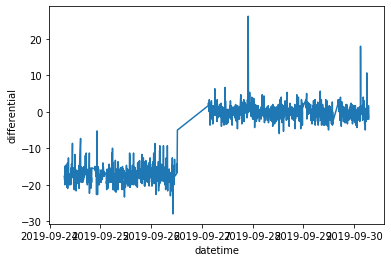

In [0]:
sns.lineplot(data = df2, x = df2.index, y = df2.differential)

#### Task 6: Define Alarm
Using what you learned from the line plot in Task 3 and the summary statistics in Task 4, define logic for an alarm that is “active” (i.e., =1) when the amperage differential is abnormal and is “inactive” (i.e., =0) when the amperage differential is normal. 

*HINT: How might the [rolling() function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) (combined with basic stat functions [mean, median, min, max, std]) help your alarm be less sensitive to sudden/short spikes (thus decreasing false alarms)? The example section in the documentation page can be helpful in understanding how to implement this function.*

In [0]:
df2['roll_differential']= df2.differential.rolling('3600s').mean()
df2


name,CR02_II01202_PV,CR02_II01212_PV,differential,roll_differential
datetime,,,,
2019-09-24 07:00:00,105.335121,123.005371,-17.670250,-17.670250
2019-09-24 07:03:00,108.340935,126.005700,-17.664765,-17.667507
2019-09-24 07:06:00,111.326775,129.992126,-18.665351,-18.000122
2019-09-24 07:09:00,110.335632,127.349434,-17.013802,-17.753542
2019-09-24 07:12:00,111.983900,129.654144,-17.670244,-17.736882
...,...,...,...,...
2019-09-30 06:48:00,117.329132,118.993700,-1.664568,0.417880
2019-09-30 06:51:00,116.000000,114.341600,1.658400,0.479906
2019-09-30 06:54:00,115.007700,115.343605,-0.335905,0.429903


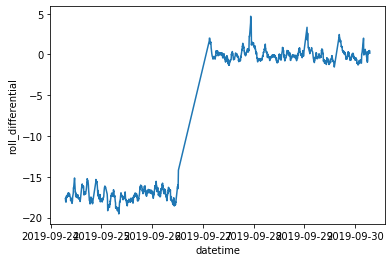

In [0]:
sns.lineplot(data = df2, x = df2.index, y = df2.roll_differential)

In [0]:
df2.loc[df2['roll_differential']<=-5, 'alarm']=1
df2.loc[df2['roll_differential']>=-5, 'alarm']=0
df2

name,CR02_II01202_PV,CR02_II01212_PV,differential,roll_differential,alarm
datetime,,,,,
2019-09-24 07:00:00,105.335121,123.005371,-17.670250,-17.670250,1.0
2019-09-24 07:03:00,108.340935,126.005700,-17.664765,-17.667507,1.0
2019-09-24 07:06:00,111.326775,129.992126,-18.665351,-18.000122,1.0
2019-09-24 07:09:00,110.335632,127.349434,-17.013802,-17.753542,1.0
2019-09-24 07:12:00,111.983900,129.654144,-17.670244,-17.736882,1.0
...,...,...,...,...,...
2019-09-30 06:48:00,117.329132,118.993700,-1.664568,0.417880,0.0
2019-09-30 06:51:00,116.000000,114.341600,1.658400,0.479906,0.0
2019-09-30 06:54:00,115.007700,115.343605,-0.335905,0.429903,0.0


In [0]:
df2.dtypes

Out[12]: name
CR02_II01202_PV float64
CR02_II01212_PV float64
differential float64
roll_differential float64
alarm float64
dtype: object

In [0]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(x = df1['datetime'],
                        y = df2['alarm'],
                        name = 'Alarm Trend',
                        mode = 'lines'))
fig1.update_layout(title = 'Alarm Trendline 09/24/2019 to 09/30/2019 ',
                 xaxis_title = 'Date',
                 yaxis_title = 'Alarm',
                 legend_title = 'Alarm Legend',
                 font = dict(family ='Courier New, monospace', size = 18, color = 'RebeccaPurple'))

fig1.show()

#### Task 7: Visualize Alarm
Add a trendline that represents your alarm to the line plot you created in task 3. Note that a good alarm will be active leading up to the failure and will be inactive after the motors were replaced. Don’t forget a title, labels, legend, etc..

In [0]:
from plotly.subplots import make_subplots
fig2 = make_subplots(specs=[[{"secondary_y": True}]])

fig2.add_trace(go.Scatter(x = df1['datetime'],
                        y = df2['CR02_II01202_PV'],
                        name = 'Motor 1',
                        mode = 'lines'))
fig2.add_trace(go.Scatter(x = df1['datetime'],
                        y = df2['CR02_II01212_PV'],
                        name = 'Motor 1',
                        mode = 'lines'))
fig2.add_trace(go.Scatter(x = df1['datetime'],
                        y = df2['alarm'],
                        name = 'Alarm Trend',
                        mode = 'lines'),secondary_y=True)
fig2.update_layout(title = '<b>Morenci Crusher 2 Feeder Motor Amps from 09/24/2019 to 09/30/2019<b> ',
                 xaxis_title = '<b>Date<b>',xaxis_rangeslider_visible=True,
                 yaxis_title = '<b>Amps<b>',
                 legend_title = '<b>Motors<b>',
                 font = dict(family ='Courier New, monospace', size = 18, color = 'RebeccaPurple'))
fig2.update_yaxes(title_text = '<b>Alarm<b>',
                 secondary_y = True)
fig2.show()